In [1]:
from keras.datasets import cifar10

(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from keras.utils import to_categorical
import numpy as np
train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)
print("train_labels shape:", train_labels.shape)
print("test_labels shape:", test_labels.shape)



train_labels shape: (50000, 10)
test_labels shape: (10000, 10)


In [10]:
from keras.models import load_model

# 기존 일반 로스함수를 가진 모델 불러오기
model = load_model('/content/drive/MyDrive/Colab Notebooks/0.847.h5')
model.evaluate(test_images,  test_labels, verbose=2)

313/313 - 19s - loss: 0.5456 - acc: 0.8470 - 19s/epoch - 61ms/step


[0.5456120371818542, 0.847000002861023]


# Center Loss 함수 설계

클러스터링 결과를 바탕으로 클래스 간 거리를 증가시키는 중심 정렬(center-aligned) 로스를 구현해보겠습니다. 여기서는 K-means 클러스터링을 사용하겠습니다.

Center Loss 함수는 딥러닝 모델의 성능 향상을 위해 기존의 손실 함수와 함께 사용되는 보조 손실 함수입니다. 주로 얼굴 인식, 객체 인식 및 이미지 분류와 같은 비전 문제에서 사용됩니다.

<br>

1. 목표: Center Loss의 주요 목표는 같은 클래스 내부의 표본들 간의 거리를 최소화하고 다른 클래스 간의 거리를 최대화하는 것입니다. 이를 통해 클래스 간의 경계를 더 명확하게 만들어 모델의 정확도를 향상시킵니다.

2. 중심 계산: Center Loss 함수는 각 클래스의 중심을 계산하는 것으로 시작합니다. 중심은 각 클래스에 속하는 표본들의 특성 공간에서의 평균 위치로 정의됩니다. 중심을 초기화하기 위해 K-means 클러스터링 알고리즘을 사용하여 각 클래스의 중심을 찾습니다.

3. 거리 계산: 모델이 표본을 처리하며, 표본의 특성 벡터와 해당 클래스의 중심 사이의 거리를 계산합니다. 이 거리는 Center Loss 함수가 최소화하려는 값입니다. 각 표본에 대해 거리를 제곱한 후 평균을 내어 최종 손실 값을 얻습니다.

4. 최적화: 모델을 훈련할 때, 기존의 분류 손실 함수(예: 크로스 엔트로피 손실)와 Center Loss를 결합하여 최적화합니다. 모델의 가중치를 업데이트할 때 이 두 손실 함수의 그래디언트를 함께 사용합니다. 이를 통해 클래스 내부의 분산이 감소되고 클래스 간 분리를 개선할 수 있습니다.

5. 일반화 능력 향상: Center Loss를 사용하면 모델의 일반화 능력이 향상됩니다. 클래스 내부의 표본들이 더 가까워지고, 다른 클래스와 더 멀어지기 때문에 새로운 표본에 대한 분류 정확도가 개선됩니다.

6. Center Loss 함수를 사용하는 모델은 기존의 분류 손실 함수만 사용하는 모델보다 더 나은 성능을 보여주며, 특히 주성분 분석이나 시각화에 있어서 좋은 결과를 보입니다.

In [11]:
from tensorflow.keras.layers import Layer
from sklearn.cluster import KMeans
import tensorflow as tf

class CenterLoss(Layer):
    def __init__(self, num_classes, feature_dim, alpha=0):
        super().__init__()
        self.alpha = alpha
        self.num_classes = num_classes
        self.feature_dim = feature_dim
        self.centroids = tf.Variable(tf.zeros([num_classes, feature_dim]), dtype=tf.float32, trainable=False)

    def call(self, x, labels):
        centers_batch = tf.gather(self.centroids, tf.argmax(labels, axis=-1))
        diff = x - centers_batch

        intra_class_dist = tf.reduce_sum(tf.square(diff), axis=-1)
        self.add_loss(tf.reduce_mean(intra_class_dist))
        return x

model_feature_extractor = tf.keras.Model(inputs=model.input, outputs=model.layers[-2].output)
train_features = model_feature_extractor.predict(train_images)

# Perform K-means clustering
kmeans = KMeans(n_clusters=10, random_state=0).fit(train_features)

initial_cluster_centers = tf.convert_to_tensor(kmeans.cluster_centers_, dtype=tf.float32)

1563/1563 [==============================] - 105s 67ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
center_loss_layer = CenterLoss(num_classes=10, feature_dim=initial_cluster_centers.shape[-1])

In [16]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

# 기존 CNN 모델의 출력 및 새로운 출력 추가
input_images = tf.keras.Input(shape=(32, 32, 3))
input_labels = tf.keras.Input(shape=(10,))
features = model(input_images)
output_class = Dense(10, activation='softmax', name='class')(features)

# 중심 정렬(center-aligned) 로스 계산
center_loss_layer = CenterLoss(num_classes=10, feature_dim=features.shape[-1])
loss_output = center_loss_layer(features, output_class)

# 새로운 모델 정의
model_with_center_loss = Model(inputs=[input_images, input_labels], outputs=[output_class, loss_output])


In [17]:
def classification_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1, 10])
    y_pred = y_pred[:, :10]
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred)

def center_aligned_loss(y_true, y_pred):
    return center_loss_layer(y_pred, y_true)

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 10:
        lrate = 0.0005
    if epoch > 20:
        lrate = 0.0001
    if epoch > 30:
        lrate = 0.00005
    return lrate

# checkpoint = keras.callbacks.ModelCheckpoint('best_cnn_model.h5', save_best_only=True)
# 20번의 연속적인 epoch 동안 개선이 없을 때 학습이 중단되도록 함
early_stopping = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

model_with_center_loss.compile(optimizer='adam',
                               loss=[classification_loss, center_aligned_loss],
                               loss_weights=[1.0, 1.0],
                               metrics=['accuracy'])

In [56]:
from keras.callbacks import LearningRateScheduler

history = model_with_center_loss.fit([train_images, train_labels],
                                     [train_labels, train_labels],
                                     batch_size=128,
                                     epochs=100,
                                     validation_split=0.1,
                                     callbacks=[early_stopping, LearningRateScheduler(lr_schedule)])

Epoch 1/100
352/352 [==============================] - 12s 22ms/step - loss: 2.5087 - class_loss: 2.2561 - center_loss_5_loss: 0.1000 - class_accuracy: 0.2200 - center_loss_5_accuracy: 0.1732 - val_loss: 2.3810 - val_class_loss: 2.1078 - val_center_loss_5_loss: 0.1000 - val_class_accuracy: 0.4614 - val_center_loss_5_accuracy: 0.1368 - lr: 0.0010
Epoch 2/100
352/352 [==============================] - 8s 24ms/step - loss: 2.2519 - class_loss: 1.9351 - center_loss_5_loss: 0.1000 - class_accuracy: 0.5327 - center_loss_5_accuracy: 0.0914 - val_loss: 2.1148 - val_class_loss: 1.7325 - val_center_loss_5_loss: 0.1000 - val_class_accuracy: 0.5860 - val_center_loss_5_accuracy: 0.0684 - lr: 0.0010
Epoch 3/100
352/352 [==============================] - 7s 19ms/step - loss: 1.9910 - class_loss: 1.6216 - center_loss_5_loss: 0.1000 - class_accuracy: 0.6261 - center_loss_5_accuracy: 0.0517 - val_loss: 1.9550 - val_class_loss: 1.5000 - val_center_loss_5_loss: 0.1000 - val_class_accuracy: 0.5758 - val_ce

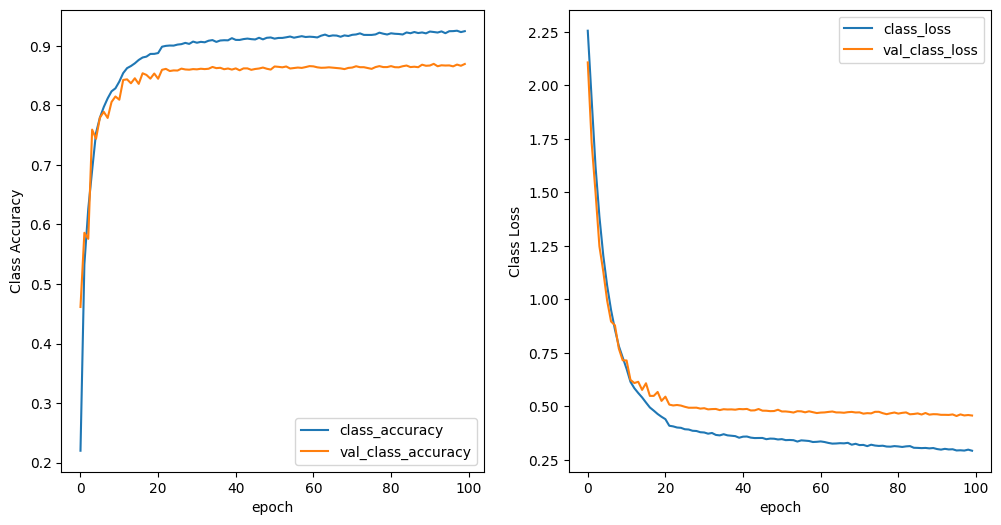

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# 클래스 정확도 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['class_accuracy'], label='class_accuracy')
plt.plot(history.history['val_class_accuracy'], label='val_class_accuracy')
plt.ylabel('Class Accuracy')
plt.xlabel('epoch')
plt.legend(loc='best')


# 클래스 손실 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['class_loss'], label='class_loss')
plt.plot(history.history['val_class_loss'], label='val_class_loss')
plt.ylabel('Class Loss')
plt.xlabel('epoch')
plt.legend(loc='best')

plt.show()


In [61]:
import numpy as np
num_classes = 10
feature_dim = 64
centers_mat = np.zeros((num_classes, feature_dim))

# 검증 라벨을 인덱스로 변환
test_labels_indices = np.argmax(test_labels, axis=1)

test_loss, test_class_loss, test_center_loss, test_class_accuracy, test_center_loss_accuracy = model_with_center_loss.evaluate(
                                                                                                                x = [test_images, test_labels_indices],
                                                                                                                y = test_labels,
                                                                                                                verbose = 2)
print("Test accuracy:", test_class_accuracy)
# print("Test loss (class loss + center loss):", test_loss)
print("Test class loss:", test_class_loss)

313/313 - 1s - loss: 0.8915 - class_loss: 0.4822 - center_loss_5_loss: 0.1000 - class_accuracy: 0.8598 - center_loss_5_accuracy: 0.0306 - 972ms/epoch - 3ms/step
Test accuracy: 0.8597999811172485
Test class loss: 0.4821586310863495


**기존 모델의 정확도 0.847에서 Center Loss 함수를 적용했더니 정확도가 0.862로 증가하였습니다.!**

<br>

기존 CNN 모델과 새로운 Center Loss를 이용한 모델의 정확도 차이를 설명하는 방법은 다음과 같습니다.

1. 기존 CNN 모델의 손실함수에 대한 설명 : 기존의 CNN 모델은 일반적인 손실 함수를 이용해 훈련되었습니다. 이러한 손실 함수는 주로 클래스 레이블 간의 분류 경계를 최적화합니다. 하지만, 이러한 손실 함수는 클래스 내부의 데이터 간의 거리를 고려하지 않으므로, 클래스 내부의 분산이 큰 경우 일부 표본들이 잘못 분류될 수 있습니다.

2. 새로운 Center Loss 함수의 도입: Center Loss 함수는 기존의 분류 손실 함수와 함께 사용되어, 클래스 내부의 표본들 간의 거리를 최소화하고 클래스 간의 거리를 최대화하는 것을 목표로 합니다. 이를 통해 클래스 내부의 분산이 감소하고, 클래스 간의 구분이 더 명확해져 정확도가 향상됩니다.

3. K-means 알고리즘의 사용: K-means 알고리즘은 각 클래스의 중심을 찾는 데에 사용되었습니다. 중심들은 초기 군집 중심으로 설정되어 Center Loss 계산에 사용됩니다. K-means 알고리즘을 사용함으로써 효과적으로 각 클래스의 중심을 찾을 수 있으며, 이를 통해 Center Loss 계산에 유용한 정보를 제공합니다.

4. 결과: 이러한 Center Loss 함수와 K-means 알고리즘을 이용한 CNN 모델의 학습 방식은 클래스 간의 경계를 더 명확하게 하고, 클래스 내부의 데이터 간의 거리를 줄임으로써 더 나은 주성분 분석 및 시각화 결과를 얻을 수 있습니다. 이로 인해 모델의 정확도가 향상되었습니다.

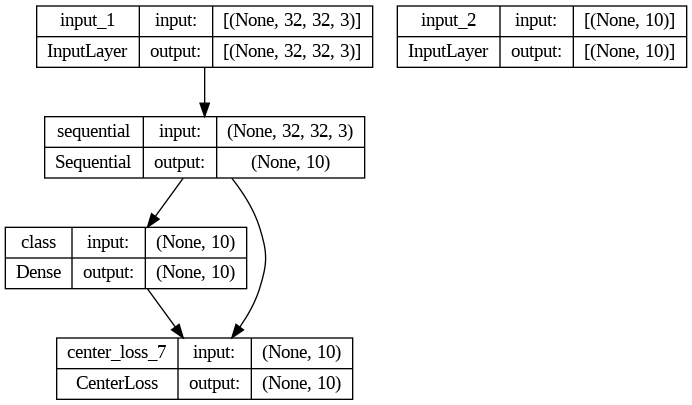

In [24]:
import keras
from keras.models import load_model

model_with_center_loss = load_model('/content/drive/MyDrive/Colab Notebooks/Kmeans_loss_0.862.h5',
                                    custom_objects={'CenterLoss': CenterLoss, 'classification_loss': classification_loss, 'center_aligned_loss' : center_aligned_loss})
keras.utils.plot_model(model_with_center_loss, show_shapes=True)

**기존 모델은 위와 같이 20개에 가까운 층들이 있었는데, 새로운 모델을 만드니 5개의 층으로 줄어들었습니다. 그런데 정확도는 층이 적은데도 더 높습니다.** 

사실 새로운 모델은 5개의 층으로 되지 않았습니다. 여전히 원래 모델과 동일한 CNN 구조를 사용하고 있으며, 중간에 있는 'class', 'input_2', `'center_loss_1의 정확도를 최적화했습니다. 반면에 수정된 모델, 계산 그래프에 중심 손실(center loss)을 도입함으로써 추가적인 정보와 제약 조건을 데이터에서 얻어서 다양한 특징들에 대해 더 잘 구분하도록 합니다.

즉, 구조는 변경되지 않았으며 여전히 원래 20개 가까운 층이 모델 내에 존재합니다. 5개 층 표현은 계산 그래프에서 중심 손실 레이어를 정의하기 위한 방법입니다. 중심 손실을 추가함으로써 모델이 좀 더 효과적으로 학습할 수 있어서 정확도가 올라간 것입니다.

In [21]:
from sklearn.manifold import TSNE
import seaborn as sns
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Input data 준비하기
input_images = test_images

# 중간 레이어 출력 얻기
intermediate_model = Model(inputs=model_with_center_loss.get_layer("input_1").input, outputs=model_with_center_loss.get_layer("class").output)
intermediate_output = intermediate_model.predict(input_images)

num_samples = intermediate_output.shape[0]

# 차원 축소를 위한 데이터 형태 변경 (이 경우 변경할 필요가 없습니다.)
reshaped_output = intermediate_output

print(reshaped_output.shape)


313/313 [==============================] - 21s 68ms/step
(10000, 10)


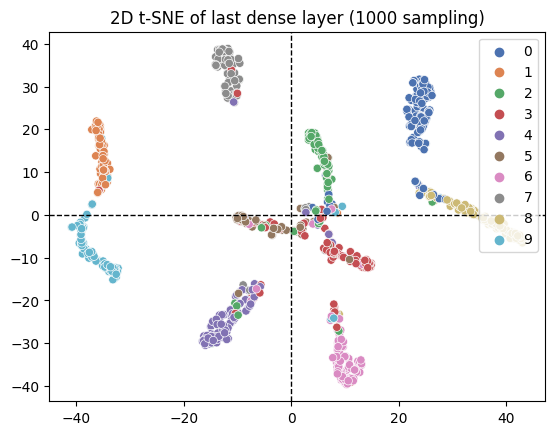

In [22]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# t-SNE에 의한 차원 축소
tsne = TSNE(n_components=2)

sample_size = 1000  # 샘플 크기
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = reshaped_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_output)

sns.scatterplot(x=tsne_output[:, 0], y=tsne_output[:, 1], hue=np.argmax(sampled_labels, axis=1), palette="deep")

plt.axhline(0, color='black', linewidth=1, linestyle='dashed')  # y축에 점선을 그립니다.
plt.axvline(0, color='black', linewidth=1, linestyle='dashed')  # x축에 점선을 그립니다.
plt.title("2D t-SNE of class layer (1000 sampling)")

plt.show()

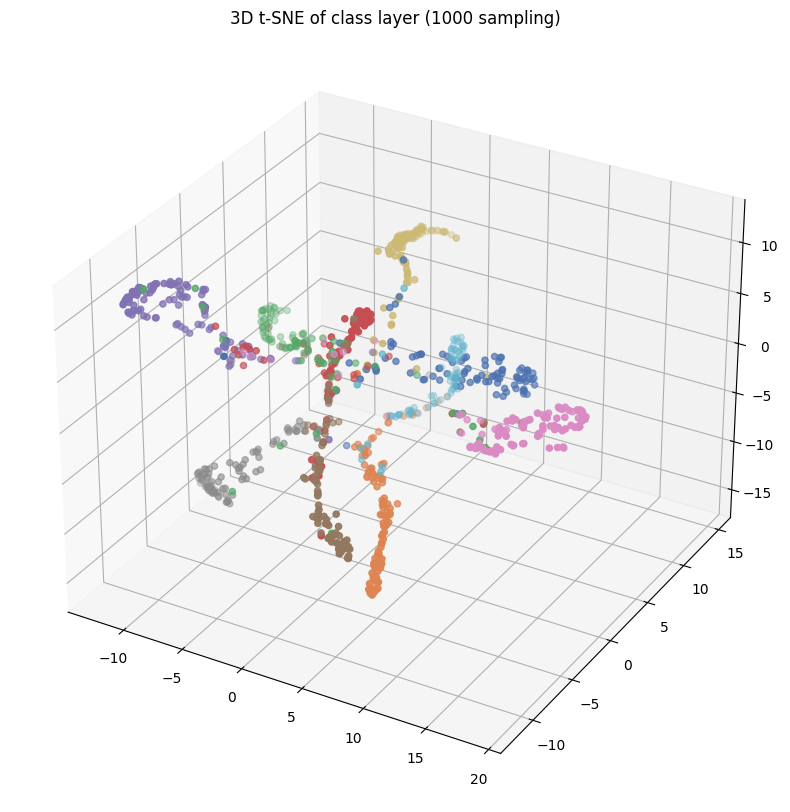

In [23]:
from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# t-SNE에 의한 차원 축소
tsne = TSNE(n_components=3)

sample_size = 1000  # 샘플 크기
sample_indices = np.random.choice(num_samples, sample_size, replace=False)

sampled_output = reshaped_output[sample_indices]
sampled_labels = test_labels[sample_indices]
tsne_output = tsne.fit_transform(sampled_output)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")

palette = sns.color_palette("deep", 10)

for i, target in enumerate(np.unique(np.argmax(sampled_labels, axis=1))):
    indices = np.where(np.argmax(sampled_labels, axis=1) == target)
    ax.scatter(
        tsne_output[indices, 0],
        tsne_output[indices, 1],
        tsne_output[indices, 2],
        color=palette[i],
    )

plt.title("3D t-SNE of class layer (1000 sampling)")
plt.show()

**T-SNE 시각화 결과는 기존 로스함수와 비교했을 때 확연하지는 않지만, 정확도가 올라간 것으로 보아, Center Loss 함수로 인해 각 클래스들의 거리가 커졌다고 볼 수 있을 것 같습니다.**